# Analyse POI density 

Remove nodes according to the density of the POIs that are there

In [1]:
# import libraries
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import networkx as nx
import numpy as np
import osmnx as ox
import shapely
import h3
import pyproj
import json

from spatial_interaction_tools import *

In [2]:
# load graph
tokyo_drive_network = nx.read_graphml('data/tokyo/drive_network_updated.graphml')

In [3]:
# set crs for Tokyo
crs = 'EPSG:6677'

In [4]:
# add geometry to graph edge
for u,v,k,d in tokyo_drive_network.edges(data = True, keys = True):
    # fix data type
    d['travel_time_mins'] = float(d['travel_time_mins'])
    
    # convert wkt to geometry
    if 'geometry' in d.keys() and isinstance(d['geometry'], str):
        d['geometry'] = shapely.wkt.loads(d['geometry'])
    
    if 'geometry' not in d.keys():
        u_data = tokyo_drive_network.nodes[u]
        v_data = tokyo_drive_network.nodes[v]
        geometry = shapely.LineString([
            [u_data['x'], u_data['y']],
            [v_data['x'], v_data['y']]
        ])
        d['geometry'] = geometry

In [5]:
# add h3 grid to graph node

# reproject
transformer = pyproj.Transformer.from_crs(crs, 'EPSG:4326', always_xy = True)

for n, d in tokyo_drive_network.nodes(data = True):
    x, y = transformer.transform(d['x'], d['y'])
    d['h3_res09'] = h3.latlng_to_cell(y, x, 9)

### Calculate POI density

In [6]:
# get POIs
pois = gpd.read_file('data/tokyo/poi/gis_osm_pois_free_1.shp')

In [7]:
tokyo_boundaries = gpd.read_file('data/tokyo_boundaries/N03-20240101_13.shp')

In [8]:
aoi = tokyo_boundaries[tokyo_boundaries['N03_004'].str.contains('区')].to_crs('EPSG:4326')

In [9]:
# get spatial index and crop
sindex = pois.sindex
aoi_geom = aoi.unary_union
matched_indeces = list(sindex.intersection(aoi_geom.bounds))
pois_clipped = pois.iloc[matched_indeces]

In [10]:
poi_commercial = pois_clipped[(((pois_clipped['code'] > 2300) & (pois_clipped['code'] < 2400)) | ((pois_clipped['code'] > 2500) & (pois_clipped['code'] < 2580)))].copy()

In [11]:
poi_commercial['h3_res09'] = poi_commercial['geometry'].apply(lambda point: h3.latlng_to_cell(point.y, point.x, 9))

In [12]:
# merge with h3 grid
tokyo_h3 = gpd.read_file('data/tokyo_boundaries/tokyo_h3_09.gpkg')

In [13]:
# count 
poi_h3 = poi_commercial.groupby('h3_res09')['osm_id'].count()

tokyo_h3_merged = tokyo_h3.merge(
    poi_h3,
    left_on = 'index',
    right_index = True,
    how = 'left'
).rename(columns = {'osm_id': 'count'}).fillna(0)

In [14]:
tokyo_h3_merged.sort_values('count', ascending = False).head(40)

,index,geometry,count
4038,892f5a32813ffff,"POLYGON ((139.77510 35.70896, 139.77454 35.710...",394.0
3111,892f5a3288fffff,"POLYGON ((139.77425 35.70592, 139.77368 35.707...",297.0
2289,892f5a32817ffff,"POLYGON ((139.77170 35.70815, 139.77113 35.709...",274.0
8180,892f5a3288bffff,"POLYGON ((139.77765 35.70673, 139.77709 35.708...",273.0
9801,892f5a32d4bffff,"POLYGON ((139.77254 35.69985, 139.77197 35.701...",255.0
9639,892f5a328c7ffff,"POLYGON ((139.77851 35.70977, 139.77794 35.711...",245.0
9999,892f5a04d0fffff,"POLYGON ((139.90144 35.78420, 139.90087 35.785...",236.0
7365,892f5aad92fffff,"POLYGON ((139.70105 35.66021, 139.70048 35.661...",228.0
2637,892f5a32e8fffff,"POLYGON ((139.79810 35.71158, 139.79753 35.713...",224.0
3785,892f5a32887ffff,"POLYGON ((139.77339 35.70289, 139.77283 35.704...",218.0


In [15]:
poi_h3_dict = tokyo_h3_merged.set_index('index')['count'].to_dict()

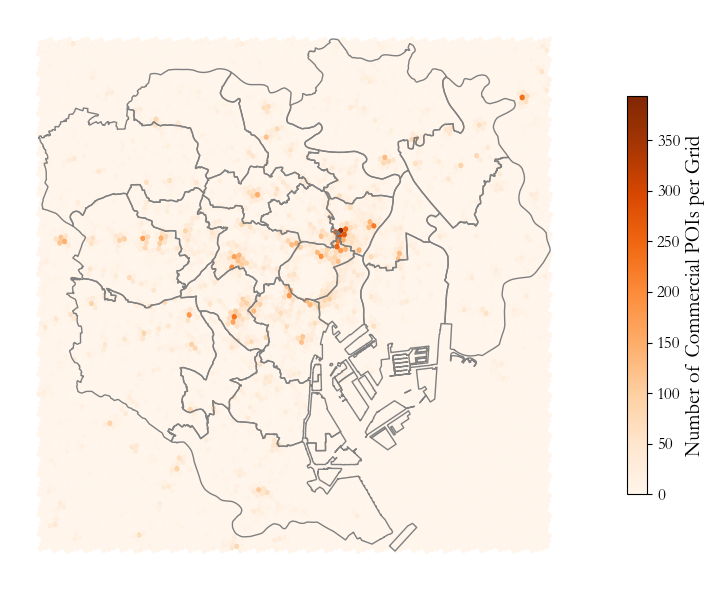

In [79]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Garamond', 'DejaVu Serif', 'Bitstream Vera Serif', 'Computer Modern Roman', 'New Century Schoolbook', 'Century Schoolbook L', 'Utopia', 'ITC Bookman', 'Bookman', 'Nimbus Roman No9 L', 'Times New Roman', 'Times', 'Palatino', 'Charter', 'serif']

fig, ax = plt.subplots(1, 1, figsize = (10, 6))

cax = tokyo_h3_merged.plot(
    column = 'count', cmap = 'Oranges', 
    ax = ax, legend = False
)
aoi.plot(facecolor = 'None', edgecolor = 'gray', ax = ax)

# Create a colorbar with custom size
sm = plt.cm.ScalarMappable(cmap='Oranges', norm=plt.Normalize(vmin = tokyo_h3_merged['count'].min(), vmax = tokyo_h3_merged['count'].max()))
sm._A = []  # Dummy array for ScalarMappable
cbar = fig.colorbar(sm, ax=ax, shrink = 0.7, fraction = 0.1)

# Change colorbar label size
cbar.set_label('Number of Commercial POIs per Grid', fontsize = 15)

# Change colorbar tick label size
cbar.ax.tick_params(labelsize=12)  # Adjust tick label size

ax.axis('off')

# plt.title('Density of Commercial POIs', fontsize = 16)
plt.tight_layout()

plt.savefig('documents/img/POI_density.png', bbox_inches = 'tight')

In [16]:
# save as json
with open('data/tokyo/h3_poi_density.json', 'w') as f:
    json.dump(poi_h3_dict, f)

In [17]:
# add h3 grid to graph node

# reproject
transformer = pyproj.Transformer.from_crs(crs, 'EPSG:4326', always_xy = True)

for n, d in tokyo_drive_network.nodes(data = True):
    x, y = transformer.transform(d['x'], d['y'])
    h3_index = h3.latlng_to_cell(y, x, 9)
    d['h3_res09'] = h3_index

    d['poi_h3'] = poi_h3_dict[h3_index]

In [18]:
[n for n in tokyo_drive_network.nodes(data = True)][:10]

[('31236562',
  {'y': '-40172.2776492199',
   'x': '-6714.702580701616',
   'street_count': '2',
   'lon': '139.759191',
   'lat': '35.6378839',
   'h3_res09': '892f5aadc93ffff',
   'poi_h3': 0.0}),
 ('31236646',
  {'y': '-40558.06491647862',
   'x': '-5012.495562733123',
   'street_count': '3',
   'lon': '139.7779888',
   'lat': '35.6344166',
   'h3_res09': '892f5aac2cfffff',
   'poi_h3': 3.0}),
 ('573342136',
  {'y': '-40591.18239009715',
   'x': '-4990.016783218739',
   'street_count': '3',
   'lon': '139.7782372',
   'lat': '35.6341182',
   'h3_res09': '892f5aac2cfffff',
   'poi_h3': 3.0}),
 ('31236657',
  {'y': '-40662.40573373009',
   'x': '-4971.7796519817375',
   'street_count': '3',
   'lon': '139.778439',
   'lat': '35.6334763',
   'h3_res09': '892f5aac2cfffff',
   'poi_h3': 3.0}),
 ('298984113',
  {'y': '-40575.13310768288',
   'x': '-5022.540229858161',
   'street_count': '3',
   'lon': '139.777878',
   'lat': '35.6342627',
   'h3_res09': '892f5aac2cfffff',
   'poi_h3': 3.0

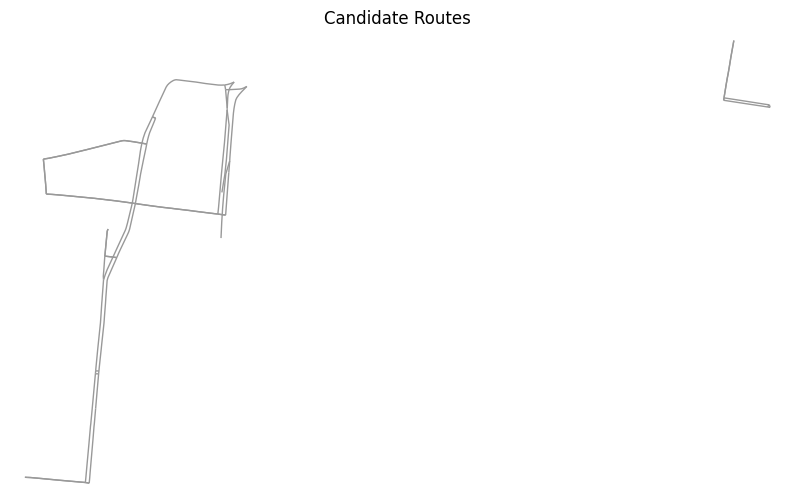

In [19]:
# look for candidates
tokyo_drive_subgraph = tokyo_drive_network.subgraph([n for n, d in tokyo_drive_network.nodes(data = True) if d['poi_h3'] > 200])

# change data type
for u,v,k,d in tokyo_drive_subgraph.edges(data = True, keys = True):
    if isinstance(d['geometry'], str):
        d['geometry'] = shapely.from_wkt(d['geometry'])


# plot
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ox.plot_graph(tokyo_drive_subgraph, ax = ax, show = False)
ax.set_title('Candidate Routes')

plt.show()

### Remove edges based on the density of POIs


In [20]:
# get length of candidates for each value
candidate_values = np.arange(0,310,10)
lengths = {}

# store the removed graphs
removed_graphs = {}
remove_lists = {}

for c in candidate_values:
    # look for candidates
    subgraph_temp = tokyo_drive_network.subgraph([n for n, d in tokyo_drive_network.nodes(data = True) if d['poi_h3'] > c])

    dist = 0
    remove_list = []
    for u,v,k,d in subgraph_temp.edges(data = True, keys = True):
        # exclude motorways
        if d['highway'] != 'motorway':
            # add to length removed
            dist += float(d['length'])
            remove_list.append((u,v,k))
    
    # add to dict
    lengths[c] = dist

    # create the removed graph
    removed_graph = tokyo_drive_network.copy()
    removed_graph.remove_edges_from(remove_list)
    # get the largest connecting component
    removed_graph = ox.truncate.largest_component(removed_graph, strongly = True)

    removed_graphs[c] = removed_graph
    remove_lists[c] = remove_list

In [21]:
[n for n in subgraph_temp.edges(data = True)][:10]

[('260539238',
  '1067372617',
  {'osmid': '1019987803',
   'oneway': 'False',
   'lanes': '4',
   'ref': '453',
   'name': '春日通り',
   'highway': 'secondary',
   'reversed': 'False',
   'length': '10.323',
   'speed_kph': '39.1',
   'travel_time': '1.0',
   'travel_time_mins': 0.016666666666666666,
   'speed_kph_calib': '18.60700851595691',
   'travel_time_calib': '2.1013587415982964',
   'travel_time_mins_calib': '0.03502264569330494',
   'geometry': <LINESTRING (-5456.255 -32394.933, -5446.022 -32396.448)>}),
 ('260539238',
  '288380045',
  {'osmid': '[956154645, 199311757]',
   'oneway': 'True',
   'lanes': '2',
   'ref': '437',
   'name': '中央通り',
   'highway': 'secondary',
   'reversed': 'False',
   'length': '201.099',
   'maxspeed': '50',
   'speed_kph': '50.0',
   'geometry': <LINESTRING (-5456.255 -32394.933, -5453.494 -32378.826, -5447.835 -32342.85...>,
   'travel_time': '14.5',
   'travel_time_mins': 0.24166666666666667,
   'speed_kph_calib': '23.794128537029298',
   'travel

### Visualise what has been done

In [22]:
# calculate the length for the original graph
orig_length = 0

for u,v,k,d in tokyo_drive_network.edges(data = True, keys = True):
    orig_length += float(d['length'])

orig_length

6426357.521000038

In [23]:
# create a dictionary that shows when an edge is removed
removed_dict = {}
for n, d in remove_lists.items():
    # for each tuple in list
    for edge in d:
        removed_dict[edge] = n

In [24]:
# add to original network as attribute
nx.set_edge_attributes(tokyo_drive_network, removed_dict, 'poi_density')

# add 0 to remaining ones
for u,v,k,d in tokyo_drive_network.edges(data = True, keys = True):
    if 'poi_density' not in d:
        d['poi_density'] = 0

In [41]:
# change wkt into geometry if not already
for u,v,k,d in tokyo_drive_network.edges(data = True, keys = True):
    if ('geometry' in d) and (isinstance(d['geometry'], str)):
        d['geometry'] = shapely.from_wkt(d['geometry'])


C:\Users\Soki\AppData\Local\Temp\ipykernel_11664\302239670.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


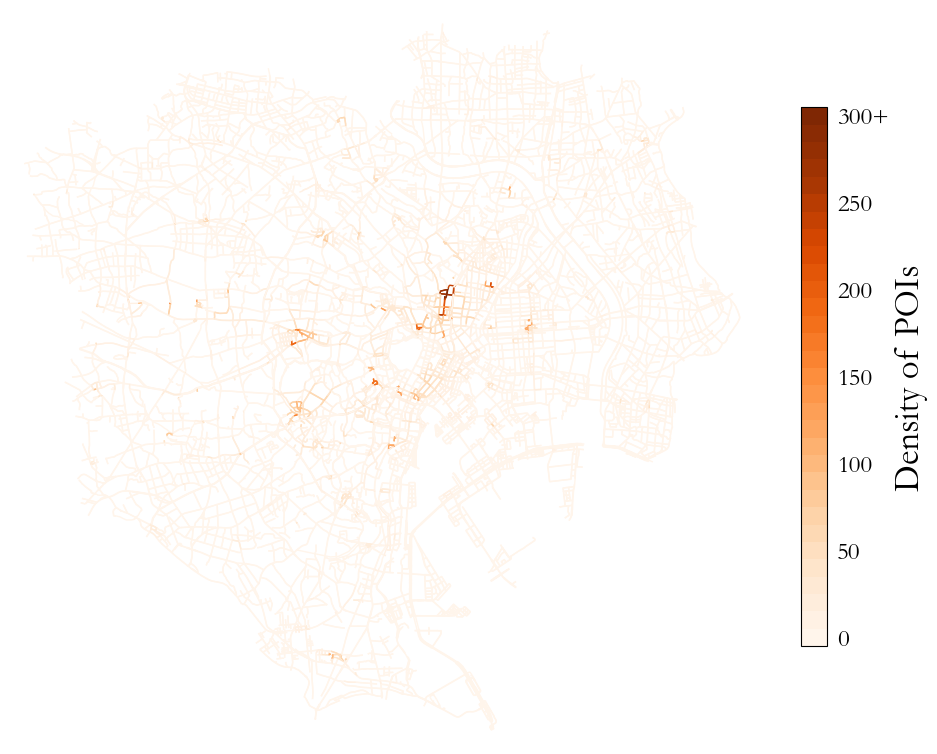

In [64]:
# set font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Garamond', 'DejaVu Serif', 'Bitstream Vera Serif', 'Computer Modern Roman', 'New Century Schoolbook', 'Century Schoolbook L', 'Utopia', 'ITC Bookman', 'Bookman', 'Nimbus Roman No9 L', 'Times New Roman', 'Times', 'Palatino', 'Charter', 'serif']

cmap_name = 'Oranges'
cmap = cm.get_cmap(cmap_name)

# Set the normalization for the attribute range
# norm = mcolors.Normalize(vmin=0, vmax=300)
bins = np.arange(-5, 310, 10)  # 0 to 300 in intervals of 10
norm = mcolors.BoundaryNorm(bins, cmap.N)

# Create a scalar mappable for the colorbar
sm = cm.ScalarMappable(cmap = cmap, norm=norm)
sm.set_array([])

# plot the edges
edge_colors = ox.plot.get_edge_colors_by_attr(tokyo_drive_network, 'poi_density', cmap = cmap_name, num_bins = len(bins) - 1)

fig, ax = ox.plot_graph(tokyo_drive_network, figsize = (12, 10), bgcolor = '#ffffff', edge_color = edge_colors, show = False, close = False)

# Set the background color of the figure
fig.patch.set_facecolor('white')
# Set the background color of the axes
ax.set_facecolor('white')

# Calculate the positions for the ticks at the center of each bin
tick_positions = [0, 50, 100, 150, 200, 250, 300]

# Add the colorbar with specific ticks and labels
cbar = fig.colorbar(sm, ax = ax, ticks = tick_positions, shrink = 0.7)
cbar.set_label('Density of POIs', fontsize = 25)

cbar.ax.yaxis.set_ticks_position('none')  # Hide the ticks (markings) on the colorbar

# Set custom tick labels, replacing 300 with '300+'
tick_labels = ['0', '50', '100', '150', '200', '250', '300+']
cbar.set_ticklabels(tick_labels, fontsize = 18)

# # add title
# ax.set_title('Edge Removal by Density of POIs')

plt.savefig('documents/img/poi_density_edges_edit.png', bbox_inches = 'tight', facecolor = 'white')


In [26]:
# change geometry into wkt
for u,v,k,d in tokyo_drive_network.edges(data = True, keys = True):
    if 'geometry' in d:
        d['geometry'] = shapely.to_wkt(d['geometry'])

# save to graphml format using OSMNX
nx.write_graphml(tokyo_drive_network, 'data/tokyo/drive_network_poi_density.graphml', encoding = 'utf-8')

In [27]:
# change dictionary of list into df
lengths_dict = {
    'poi_density': [],
    'length_removed': [],
    'percentage_left': []
}

for n, d in lengths.items():
    lengths_dict['poi_density'].append(n)
    lengths_dict['length_removed'].append(lengths[n])
    lengths_dict['percentage_left'].append(1 - lengths[n] / orig_length)

lengths_df = pd.DataFrame(lengths_dict)

In [28]:
lengths_df.to_csv('data/tokyo/poi_density_street_length.csv', index = False)

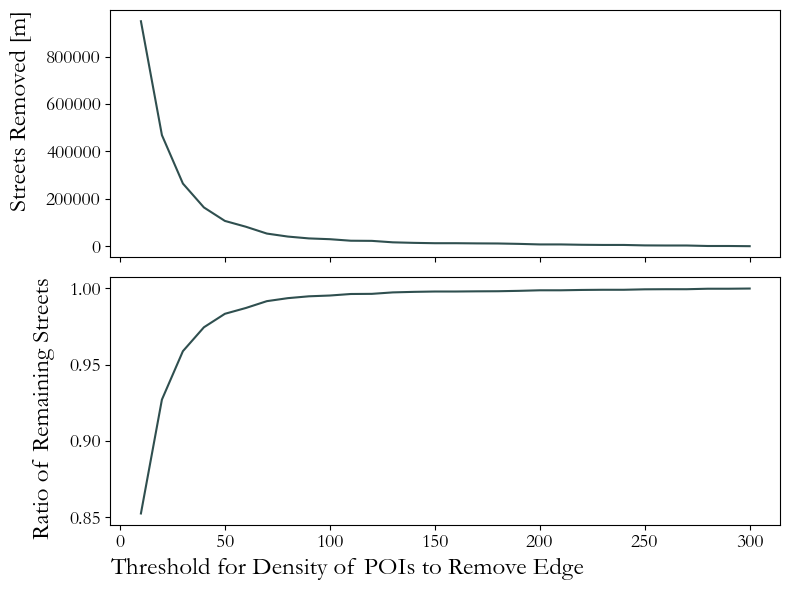

In [68]:
# Create the subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

# Plot data on the first subplot
ax1.plot(lengths_df.iloc[1:]['poi_density'], lengths_df.iloc[1:]['length_removed'], color = 'darkslategray')
ax1.set_ylabel('Streets Removed [m]', labelpad=10, fontsize = 18, loc = 'top')

# Plot data on the second subplot
ax2.plot(lengths_df.iloc[1:]['poi_density'], lengths_df.iloc[1:]['percentage_left'], color = 'darkslategray')
ax2.set_ylabel('Ratio of Remaining Streets', labelpad=10, fontsize = 18, loc = 'top')
ax2.set_xlabel('Threshold for Density of POIs to Remove Edge', fontsize = 18, loc = 'left')

# make ticks bigger
ax1.tick_params(axis = 'y', labelsize = 14)
ax2.tick_params(axis = 'x', labelsize = 14)
ax2.tick_params(axis = 'y', labelsize = 14)

# plt.suptitle('Removal of Edges According to the Density of Commercial POIs', fontsize = 18)

plt.tight_layout()

plt.savefig('documents/img/POI_removal_lengths.png', bbox_inches = 'tight')


### Merge with zone data

In [31]:
# load the zones data
zones = gpd.read_file(os.path.join('data', 'H30_gis', 'H30_kzone.shp'))

# extract the Tokyo Metropolitan Area
zones_tokyo = zones[zones['kzone'] < 700]

# create zone list
zones_dict = []
for idx, area in zones_tokyo.iterrows():
    node_id = 'zone_' + str(area['kzone'])
    c = area['geometry'].centroid
    y = c.y
    x = c.x
    zones_dict.append((node_id, {
        'y': y,
        'x': x,
        'zone_int': area['kzone'],
        'zone_name': node_id
    }))

In [32]:
# add the zones to the network
for n, G in removed_graphs.items():
    print(f'Working on network for {n}')
    # the centroid of the zones will be connected to the network to the nearest node
    edge_dict = []
    for z in zones_dict:
        id = z[0]
        data = z[1]
        nearest_node = ox.nearest_nodes(G, data['x'], data['y'], return_dist = True)
        data_dict = {
            'length': nearest_node[1],
            'travel_time_mins': 0.1,
            'type': 'connection'
        }
        edge_dict.append((id, nearest_node[0], data_dict))
        edge_dict.append((nearest_node[0], id, data_dict))
    
    # add to network
    G.add_nodes_from(zones_dict)
    G.add_edges_from(edge_dict)

Working on network for 0
Working on network for 10
Working on network for 20
Working on network for 30
Working on network for 40
Working on network for 50
Working on network for 60
Working on network for 70
Working on network for 80
Working on network for 90
Working on network for 100
Working on network for 110
Working on network for 120


KeyboardInterrupt: 

In [33]:
od_test = pd.read_pickle('data/tokyo/pt_network_time_weight_updated.pkl')

In [34]:
od_test

,source,target,drive_time,multilayer_time,multilayer_path,rail,bus,car,motorbike,bicycle,pedestrian,other,unknown,total
0,10,10,0.000000,0.000000,[zone_10],2325.0,0.0,1304.0,0.0,739.0,25232.0,0.0,853.0,30453.0
1,10,11,3.905000,25.415646,"[zone_10, street_1866774276, street_558686762,...",3321.0,0.0,1283.0,0.0,144.0,449.0,0.0,79.0,5276.0
2,10,12,2.638333,24.518493,"[zone_10, street_1866774276, street_558689164,...",4026.0,0.0,1878.0,0.0,460.0,4703.0,0.0,0.0,11067.0
3,10,13,1.803333,20.986065,"[zone_10, street_1866774276, street_558689164,...",2894.0,0.0,1110.0,0.0,233.0,2375.0,0.0,0.0,6612.0
4,10,20,3.503333,32.875049,"[zone_10, street_1866774276, street_558689164,...",3110.0,98.0,1149.0,0.0,0.0,849.0,0.0,0.0,5206.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13220,634,630,9.111667,39.814964,"[zone_634, street_10991775829, street_58245660...",295.0,147.0,179.0,268.0,0.0,0.0,0.0,0.0,889.0
13221,634,631,8.141667,30.990253,"[zone_634, street_10991775829, street_58245660...",226.0,1438.0,3848.0,594.0,5307.0,510.0,0.0,160.0,12083.0
13222,634,632,13.373333,46.693605,"[zone_634, street_10991775829, street_58245660...",371.0,0.0,413.0,0.0,317.0,0.0,0.0,0.0,1101.0
13223,634,633,10.261667,48.061278,"[zone_634, street_10991775829, street_58245660...",1637.0,771.0,3701.0,185.0,1530.0,605.0,0.0,0.0,8429.0


In [ ]:
{n: len(G) for n, G in removed_graphs.items()}

{0: 528,
 10: 9524,
 20: 11395,
 30: 12236,
 40: 12764,
 50: 13017,
 60: 13145,
 70: 13300,
 80: 13348,
 90: 13401,
 100: 13410,
 110: 13460,
 120: 13462,
 130: 13498,
 140: 13513,
 150: 13515,
 160: 13515,
 170: 13520,
 180: 13522,
 190: 13524,
 200: 13530,
 210: 13530,
 220: 13535,
 230: 13540,
 240: 13540,
 250: 13554,
 260: 13554,
 270: 13554,
 280: 13557,
 290: 13557,
 300: 13562}

In [ ]:
[n for n, d in zones_dict]

['zone_430',
 'zone_34',
 'zone_122',
 'zone_131',
 'zone_348',
 'zone_135',
 'zone_243',
 'zone_123',
 'zone_30',
 'zone_20',
 'zone_138',
 'zone_32',
 'zone_110',
 'zone_112',
 'zone_346',
 'zone_412',
 'zone_132',
 'zone_134',
 'zone_22',
 'zone_111',
 'zone_240',
 'zone_133',
 'zone_24',
 'zone_335',
 'zone_422',
 'zone_13',
 'zone_435',
 'zone_121',
 'zone_130',
 'zone_433',
 'zone_347',
 'zone_421',
 'zone_33',
 'zone_437',
 'zone_344',
 'zone_21',
 'zone_231',
 'zone_10',
 'zone_31',
 'zone_432',
 'zone_136',
 'zone_434',
 'zone_241',
 'zone_436',
 'zone_345',
 'zone_137',
 'zone_242',
 'zone_23',
 'zone_124',
 'zone_431',
 'zone_349',
 'zone_120',
 'zone_341',
 'zone_332',
 'zone_330',
 'zone_631',
 'zone_320',
 'zone_630',
 'zone_340',
 'zone_336',
 'zone_632',
 'zone_312',
 'zone_331',
 'zone_230',
 'zone_333',
 'zone_633',
 'zone_343',
 'zone_622',
 'zone_310',
 'zone_342',
 'zone_334',
 'zone_11',
 'zone_235',
 'zone_222',
 'zone_12',
 'zone_322',
 'zone_634',
 'zone_210',


In [ ]:
distance_dict = {}
path_dict = {}
for n, G in removed_graphs.items():
    print(f'Processing {n}')
    distance_dict[n] = {}
    path_dict[n] = {}
    for u in [n for n, d in zones_dict]:
        distance, path = nx.single_source_dijkstra(G, source = u, weight='travel_time_mins')
        for v, dist in distance.items():
            if 'zone' in v: 
                distance_dict[n][(u, v)] = dist
        for v, p in path.items():
            if 'zone' in v: 
                path_dict[n][(u, v)] = p

Processing 0
Processing 10
Processing 20
Processing 30
Processing 40
Processing 50
Processing 60
Processing 70
Processing 80
Processing 90
Processing 100
Processing 110
Processing 120
Processing 130
Processing 140
Processing 150
Processing 160
Processing 170
Processing 180
Processing 190
Processing 200
Processing 210
Processing 220
Processing 230
Processing 240
Processing 250
Processing 260
Processing 270
Processing 280
Processing 290
Processing 300


In [ ]:
# change into data frame

# initialise columns
distance_dict_edit = {
    'source': [],
    'target': []
}
for n in distance_dict:
    distance_dict_edit[f'driving_time_{n}'] = []
for n in path_dict:
    distance_dict_edit[f'driving_path_{n}'] = []


for u in [n for n, d in zones_dict]:
    for v in [n for n, d in zones_dict]:
        distance_dict_edit['source'].append(u)
        distance_dict_edit['target'].append(v)

        for idx, dict in distance_dict.items():
            distance_dict_edit[f'driving_time_{idx}'].append(dict[(u,v)])
        for idx, dict in path_dict.items():
            distance_dict_edit[f'driving_path_{idx}'].append(dict[(u,v)])
        

# save as df
distance_df = pd.DataFrame(distance_dict_edit)

In [ ]:
# save as pickle
distance_df.to_pickle('data/tokyo/travel_time_poi.pkl')

## Calculate Efficiency

In [47]:
# load distance
distance_df = pd.read_pickle('data/tokyo/travel_time_poi.pkl')

In [48]:
# remove the 'zone_
for c in ['source', 'target']:
    distance_df[c] = distance_df[c].str.replace('zone_', '').astype(int)

In [49]:
# load OD matrix
od_matrix = pd.read_pickle('data/tokyo/pt_network_time_weight_updated.pkl')

In [50]:
# merge dataframes
distance_merged = distance_df.merge(
    od_matrix,
    on = ['source', 'target']
)

In [51]:
# load lengths
lengths_df = pd.read_csv('data/tokyo/poi_density_street_length.csv')

In [52]:
lengths_df

,poi_density,length_removed,percentage_left
0,0,4342285.673,0.324301
1,10,948776.524,0.852362
2,20,468806.009,0.927049
3,30,264619.221,0.958823
4,40,163997.164,0.974481
5,50,107151.285,0.983326
6,60,82593.172,0.987148
7,70,53824.836,0.991624
8,80,41175.834,0.993593
9,90,33419.207,0.994800


In [53]:
efficiency_dict = {
    'density': [],
    'efficiency': []
}

mask = (distance_merged['source'] != distance_merged['target'])
vehicles_total = distance_merged['vehicle'].sum()
for n in range(10, 310, 10):
    efficiency_dict['density'].append(n)
    # mask = ((distance_merged['vehicle'] > 0) & (distance_merged[f'driving_time_{n}'] > 0))
    efficiency = (distance_merged[mask]['vehicle'] / distance_merged[mask][f'driving_time_{n}']).sum() / vehicles_total
    efficiency_dict['efficiency'].append(efficiency)

orig_efficiency = (distance_merged[mask]['vehicle'] / distance_merged[mask][f'drive_time']).sum() / vehicles_total

efficiency_df = pd.DataFrame(efficiency_dict)

In [54]:
efficiency_df_merged = efficiency_df.merge(
    lengths_df,
    how = 'left',
    left_on = 'density',
    right_on = 'poi_density'
)

In [55]:
efficiency_df_merged

,density,efficiency,poi_density,length_removed,percentage_left
0,10,0.075284,10,948776.524,0.852362
1,20,0.087113,20,468806.009,0.927049
2,30,0.094238,30,264619.221,0.958823
3,40,0.097081,40,163997.164,0.974481
4,50,0.100712,50,107151.285,0.983326
5,60,0.101641,60,82593.172,0.987148
6,70,0.102598,70,53824.836,0.991624
7,80,0.103198,80,41175.834,0.993593
8,90,0.103630,90,33419.207,0.994800
9,100,0.104242,100,30094.508,0.995317


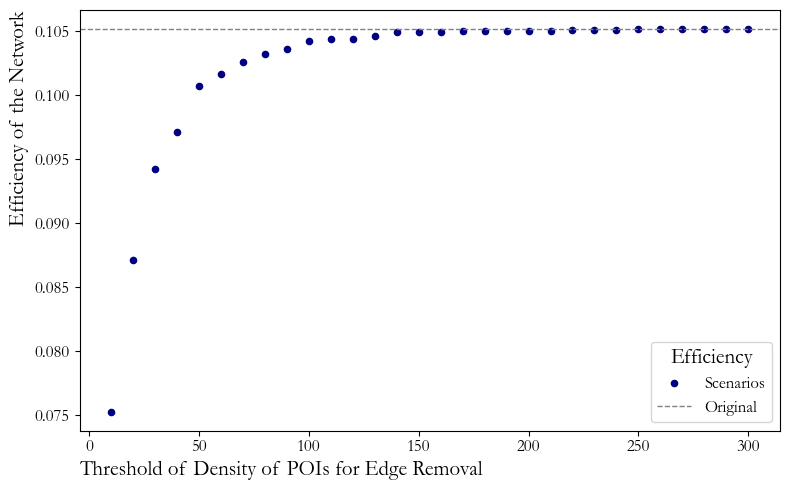

In [69]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Garamond', 'DejaVu Serif', 'Bitstream Vera Serif', 'Computer Modern Roman', 'New Century Schoolbook', 'Century Schoolbook L', 'Utopia', 'ITC Bookman', 'Bookman', 'Nimbus Roman No9 L', 'Times New Roman', 'Times', 'Palatino', 'Charter', 'serif']

# plot the results for all
fig, ax = plt.subplots(1, 1, figsize = (8, 5))

efficiency_df_merged.plot.scatter(
    x = 'density',
    y = 'efficiency',
    s = 20,
    c = 'navy',
    ax = ax,
    label = 'Scenarios'
)

ax.axhline(
    y = orig_efficiency, 
    color = 'gray', linestyle='--',
    label = 'Original',
    linewidth = 1
)

ax.legend(title = 'Efficiency', fontsize = 12, title_fontsize = 15)
# label
ax.set_xlabel('Threshold of Density of POIs for Edge Removal', fontsize = 15, loc = 'left')
ax.set_ylabel('Efficiency of the Network', fontsize = 15, loc = 'top')
# plt.title('Change in the Efficiency of the Network')

# size of ticks
ax.tick_params(axis = 'x', labelsize = 12)
ax.tick_params(axis = 'y', labelsize = 12)

plt.tight_layout()
plt.savefig('documents/img/efficiency_poi.png', bbox_inches = 'tight')

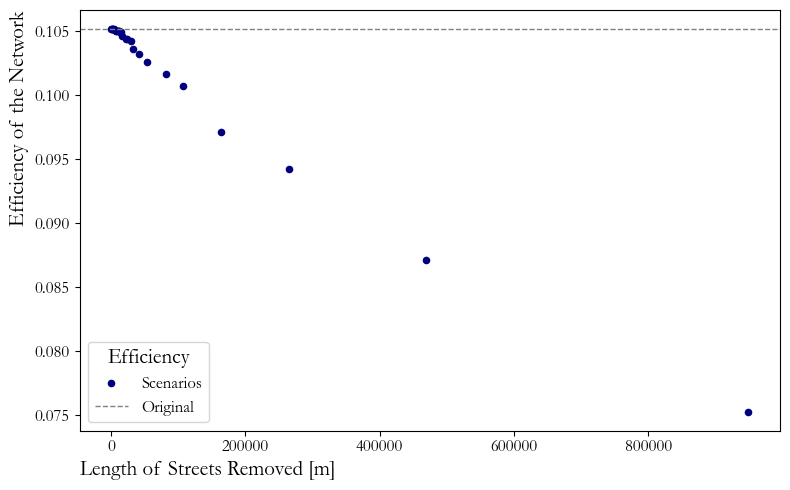

In [70]:
# plot the results for all
fig, ax = plt.subplots(1, 1, figsize = (8, 5))

efficiency_df_merged.plot.scatter(
    x = 'length_removed',
    y = 'efficiency',
    s = 20,
    c = 'navy',
    ax = ax,
    label = 'Scenarios'
)

ax.axhline(
    y = orig_efficiency, 
    color = 'gray', linestyle='--',
    label = 'Original',
    linewidth = 1
)

ax.legend(title = 'Efficiency', fontsize = 12, title_fontsize = 15)

ax.set_xlabel('Length of Streets Removed [m]', fontsize = 15, loc = 'left')
ax.set_ylabel('Efficiency of the Network', fontsize = 15, loc = 'top')
# plt.title('Change in the Efficiency of the Network')

# size of ticks
ax.tick_params(axis = 'x', labelsize = 12)
ax.tick_params(axis = 'y', labelsize = 12)

plt.tight_layout()
plt.savefig('documents/img/efficiency_poi_by_length.png', bbox_inches = 'tight')